## Vision Transformers
- [AN IMAGE IS WORTH 16 X 16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://arxiv.org/abs/2010.11929)

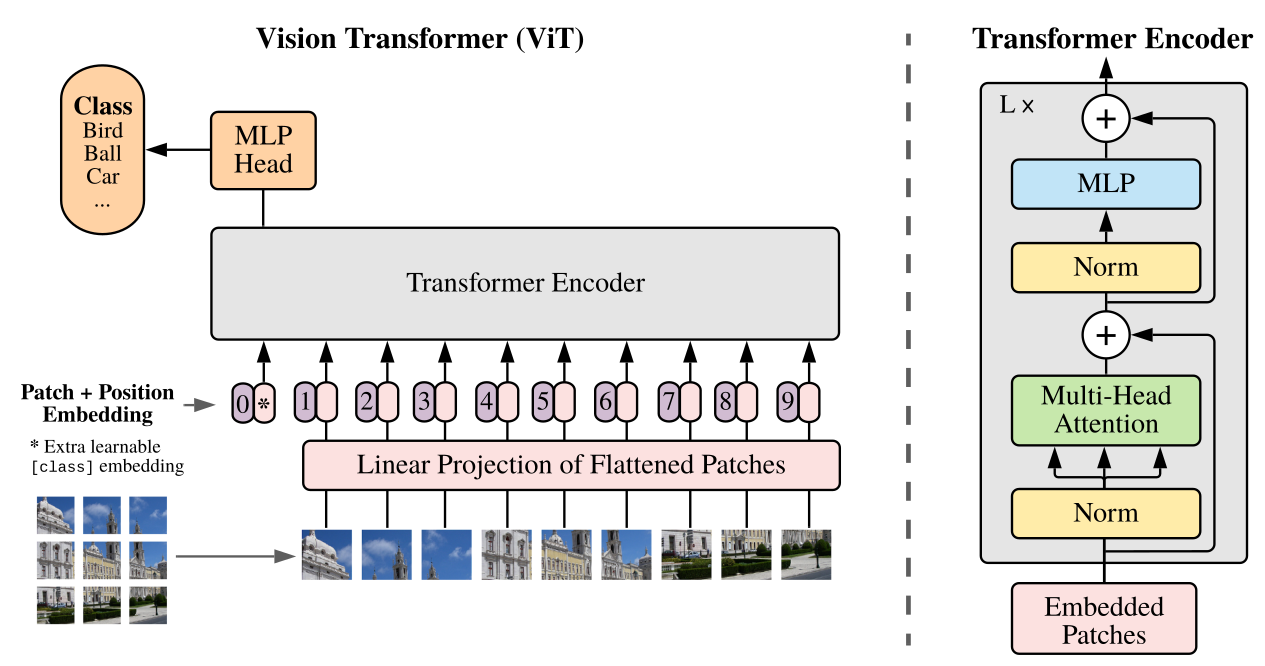

## Imports

In [1]:
import torch
import torch.nn as nn

### CONSTANTS

We'll be defining some hyperparmeters for the model, (correspond to VIT-small model)

In [2]:
img_size = 224
patch_size = 16   # image is divided into patches of 16 x16 pixels
num_patches = (img_size // patch_size) * (img_size // patch_size)

# transformer parameters
embed_dim = 384
num_heads = 6
depth = 12

## Vision Transformer Architecture

- Only Encoder from original Transformer paper
- Cover different modules in vision Transformers
    - Patch embedding
    - Cls Token, Positional embedding
    - Layer Normalization
    - Self-Attention 
    - MLP Layer
    - Transformer block
    - Putting it together


### Patch Embedding

In [3]:
class PatchEmbed(nn.Module):
    """ Generate Patches from input image, create embeddings for each patch """
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [4]:
# (Batch size, RGB channels, height, width)
input_data = torch.Tensor(1, 3, img_size, img_size)
patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=3, embed_dim=embed_dim)
patch_embed_output = patch_embed(input_data)
print(f"Patch embedding output shape = {patch_embed_output.shape}")

Patch embedding output shape = torch.Size([1, 196, 384])


### Cls Token, Position Embedding
- Need a mechanism to inform the model of 
    - Embedding class
    - Order of patches
- Positional embeddings can be either
    - Derived from mathematical function (usually involves sines and cosines of input index)
    - Learnt by model (which is current case)
    
- **Need for Classification token?**

In [5]:
# add class token for each patch
cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
cls_token = cls_token.expand(input_data.shape[0], -1, -1)
cls_token_output = torch.cat((cls_token, patch_embed_output), dim=1)
print(f"Class token output shape = {cls_token_output.shape}")

Class token output shape = torch.Size([1, 197, 384])


**Note the usage of nn.Parameter, and not something like nn.Linear**

In [6]:
# add positional encoding to each token
pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

# To align with original architecture, we need to add 
# dropout on the position embedding. For now, we'll define
# dropout probability as 0
pos_drop = nn.Dropout(p=0)

pos_embed_output = cls_token_output + pos_drop(pos_embed)
print(f"Position Embedding output shape = {pos_embed_output.shape}")

Position Embedding output shape = torch.Size([1, 197, 384])


### Self-Attention

In [7]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_drop, proj_drop):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x) # (1, 197, 3 * 384), contains query, key and values
        qkv = qkv.reshape(B, N, 3, self.num_heads, C // self.num_heads)  # (1, 197, 3, 6, 64)
        
        # (qkv, batch_size, num_heads, num_tokens, dim_per_head)
        qkv =qkv.permute(2, 0, 3, 1, 4)  # (3, 1, 6, 197, 64)
        
        # query, key, values all are of (1,6,197,64) shape
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # query (1,6,197,64) * key (1,6,64, 197) = (1,6,197,197)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # attn (1,6,197,197) * value (1,6,197,64) = (1,6,197,64)
        x = (attn @ v)
        
        # (1,6,197,64) -> (1,197,6,64) -> (1,197,384)
        x = x.transpose(1, 2).reshape(B, N, C)
        
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn

In [8]:
attention_module = Attention(dim = embed_dim, num_heads = num_heads, attn_drop =0.0, proj_drop =0.0 )
attn_output, attn = attention_module(pos_embed_output)
print(f"Attention output shape = {attn_output.shape}")
print(f"Attention shape = {attn.shape}")

Attention output shape = torch.Size([1, 197, 384])
Attention shape = torch.Size([1, 6, 197, 197])


### MLP module

In [9]:
class Mlp(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hid_dim, out_dim)
        self.drop = nn.Dropout(0.0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

### Transformer block

In [10]:
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, attn_drop=0, proj_drop=0)
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_dim=dim, hid_dim=mlp_hidden_dim, out_dim=dim)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x, attn

In [11]:
transformer_block = Block(dim=embed_dim, num_heads=3, mlp_ratio=4)
transformer_block_output, _ = transformer_block(pos_embed_output)
print(f"Transformer block output shape = {transformer_block_output.shape}")

Transformer block output shape = torch.Size([1, 197, 384])


### Putting it altogether

In [12]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim, depth, num_heads, mlp_ratio):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=0.0)

        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio)
            for i in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)


    def prepare_tokens(self, x):
        B, nc, w, h = x.shape
        x = self.patch_embed(x)  # patch linear embedding

        # add the [CLS] token to the embed patch tokens
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # add positional encoding to each token
        x = x + self.pos_embed
        return self.pos_drop(x)

    def forward(self, x):
        attn_maps = []
        x = self.prepare_tokens(x)
        for blk in self.blocks:
            x, attn_map = blk(x)
            attn_maps.append(attn_map)
        x = self.norm(x)
        return x, attn_maps

In [13]:
vit = VisionTransformer(img_size=img_size, patch_size=patch_size, in_chans=3, 
                        embed_dim=embed_dim, depth=depth, num_heads=num_heads, mlp_ratio=4)

In [15]:
vit_output, attn_maps = vit(input_data)

In [16]:
vit_output.shape, len(attn_maps)

(torch.Size([1, 197, 384]), 12)

In [17]:
[x.shape for x in attn_maps]

[torch.Size([1, 6, 197, 197]),
 torch.Size([1, 6, 197, 197]),
 torch.Size([1, 6, 197, 197]),
 torch.Size([1, 6, 197, 197]),
 torch.Size([1, 6, 197, 197]),
 torch.Size([1, 6, 197, 197]),
 torch.Size([1, 6, 197, 197]),
 torch.Size([1, 6, 197, 197]),
 torch.Size([1, 6, 197, 197]),
 torch.Size([1, 6, 197, 197]),
 torch.Size([1, 6, 197, 197]),
 torch.Size([1, 6, 197, 197])]

## Visualize Attention

## References